## IDS576 - Team 3
#### Training MNIST with Basic CNN and Random Feature Nullification

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import SubsetRandomSampler, TensorDataset, DataLoader
import torch.nn.functional as F
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
%config IPCompleter.greedy = True
random_seed = 0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
import numpy as np
def get_train_data_stats(train_data):
    # use np.concatenate to stick all the images together to form a 1600000 X 32 X 3 array\
    x = np.concatenate([np.asarray(train_data[i][0]) for i in range(len(train_data))])
    print(x.shape)
    # calculate the mean and std along the (0, 1) axes
    train_mean = np.mean(x, axis=(0, 1))
    train_std = np.std(x, axis=(0, 1))
    print(train_mean, train_std)
    return train_mean, train_std

In [4]:
# load the training data for determination of mean and std
data_path = '~/IDS576/data'
train_data = datasets.MNIST(root=data_path, train=True, download=True)
train_mean, train_std = get_train_data_stats(train_data)
print(train_mean/255, train_std/255)

(1680000, 28)
33.318421449829934 78.56748998339798
0.1306604762738429 0.30810780385646264


In [39]:
train_transform = transforms.Compose([
        transforms.ToTensor()])
    
val_transform = transforms.Compose([
        transforms.ToTensor()])

In [40]:
# Download train and test data
data_path = '~/IDS576/data'
trainset = datasets.MNIST(root=data_path, train=True, download=True, transform=train_transform)
valset = datasets.MNIST(root=data_path, train=True, download=True, transform=val_transform)
testset = datasets.MNIST(root=data_path, train=False, download=True, transform=val_transform)

In [111]:
# Split train data in to train and validation data using torch dataset and utils.data modules

val_size = .2
n_train = len(trainset)

# get train set indices and split point based on val size
indices = list(range(n_train))
split = int(np.floor(val_size * n_train))

# shuffle trainset indices
np.random.seed(random_seed)
np.random.shuffle(indices)

# split train into train and val with shuffled indices at split point. 
train_idx, val_idx = indices[split:], indices[:split]

# Create train and val samplers based in split indices for use with DataLoader batch sampling
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

batch_size = 20
n_trn = n_train*(1-val_size)
batches = n_trn/batch_size

# CUDA settings
num_workers = 0 # allows preload of next batch, but greater than zero isn't recommended for cuda ops
pin_memory = True

train_dl = DataLoader(
    trainset, batch_size=batch_size, sampler=train_sampler,
    num_workers=num_workers, pin_memory=pin_memory)

val_dl = DataLoader(
    valset, batch_size=batch_size, sampler=val_sampler,
    num_workers=num_workers, pin_memory=pin_memory)

def single_dl(xy, batch_size=1):
    return DataLoader(xy, batch_size=batch_size, num_workers=1, pin_memory=pin_memory)

In [114]:
classes = trainset.classes
classdict = {label: name for label, name in enumerate(classes)}
print(classes)

['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


In [122]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    xb = xb.to(device)
    yb = yb.to(device)
    correct = 0
    output = model(xb)
    _, preds = torch.max(output, 1)
    correct = torch.sum(preds == yb)
    acc = correct.double()/len(yb)
    loss = loss_func(output, yb)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    return loss.item(), len(xb), acc   

def fit(epochs, model, loss_func, opt, train_dl, val_dl):
    mod = n_trn/(batch_size*20)
    running_corrects = 0
    val_accs = []
    val_losses = []
    for epoch in range(epochs):
        since = time.time()
        model.train()
        #i=0
        print(f'Epoch {epoch+1}/{epochs}: [', end='')
        for i, (xb, yb) in enumerate(train_dl):
            if not i % mod:
                print('*', end='')
            loss_batch(model, loss_func, xb, yb, opt)
            #i+=1
        print(']', end='')
        model.eval()
        print(' Val Loss: ', end='')
        with torch.no_grad():
            losses, nums, acc = zip(*[loss_batch(model, loss_func, xb, yb) for xb, yb in val_dl])
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        val_acc = np.sum(np.multiply(acc, nums)) / np.sum(nums)
        
        # Save history
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'{val_loss:6.4f}, Val Acc: {val_acc:6.4f} ', end='')
        until = time.time()
        print(f'Elapsed (sec): {until-since:<5.1f}')
    return val_accs, val_losses

In [123]:
class MNIST(nn.Module):
    
    def __init__(self):
        super(MNIST, self).__init__()
        self.conv1 = nn.Conv2d(1, 28, 3) #1 in channel, 28 filters, 3x3 filter size
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(28 * 13 * 13, 128)
        self.dropout = nn.Dropout(p=.2)
        self.fc2 = nn.Linear(128, 10)
                             
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 28 * 13 * 13) # Flattens from 28 13*13 (post pool, no pad) 1d 28*13*13 tensor
        x = F.relu(self.fc1(x)) # 28*13*13 inputs, 128 outputs
        x = self.dropout(x)
        x = F.relu(self.fc2(x)) # 128 inputs, 10 outputs to match num classes
        return x


In [131]:
import torch.nn as nn
import torch
import numpy as np

class RFN(nn.Module):
    '''Wrapper class that takes any nn.Module based model and adds an RFN layer prior to all other layers.'''
    
    
    def __init__(self, model, mu=.1, sigma=.05, rfn_flag=True):
        super(RFN, self).__init__()
        self.model = model
        self.mu = mu
        self.sigma = sigma
        self.rfn_flag = rfn_flag
        self.shape_vals = None

    def forward(self, x):
        if self.rfn_flag:
            x = self.random_masks(x) * x
            x = self.model(x)
        else:
            x = self.model(x)
        return x
    
    
    def random_masks(self, x):
        # Set various shape values once to speed processing
        if self.shape_vals is None:
            self.shape_vals = x.size(), x[0].size(), x[0].nelement()
            #print(self.shape_vals)

        # Create ones array of size (batch,channel,horiz,vert)
        masks = np.ones(self.shape_vals[0])

        # Create random masks for each sample in the batch
        for mask in masks:
            zero_cnt = np.absolute(int(np.ceil((self.sigma * np.random.randn() + self.mu) * self.shape_vals[2])))
            zero_idx = np.random.choice(self.shape_vals[2], zero_cnt, replace=False)
            mask.reshape(self.shape_vals[2])[zero_idx] = 0
            mask.reshape(self.shape_vals[1])
        return torch.tensor(masks, dtype=torch.float, device=device)

In [125]:
from collections import defaultdict
# Create history dict for all models with validation accuracy and loss per epoch
history = defaultdict(list)

In [101]:
# Train MNIST without RFN as reference
epochs = 10
mnist_ref = MNIST()
mnist_ref.to(device)
loss_func = nn.CrossEntropyLoss()
opt = optim.SGD(mnist_ref.parameters(), lr=0.001, momentum=0.9)
fit(epochs, mnist_ref, loss_func, opt, train_dl, val_dl)

Epoch 1/10: [********************] Val Loss: 0.2730, Val Acc: 0.9172 Elapsed (sec): 16.2 
Epoch 2/10: [********************] Val Loss: 0.1681, Val Acc: 0.9519 Elapsed (sec): 16.4 
Epoch 3/10: [********************] Val Loss: 0.1347, Val Acc: 0.9591 Elapsed (sec): 16.4 
Epoch 4/10: [********************] Val Loss: 0.1202, Val Acc: 0.9627 Elapsed (sec): 16.3 
Epoch 5/10: [********************] Val Loss: 0.1047, Val Acc: 0.9684 Elapsed (sec): 16.4 
Epoch 6/10: [********************] Val Loss: 0.0940, Val Acc: 0.9708 Elapsed (sec): 16.3 
Epoch 7/10: [********************] Val Loss: 0.0870, Val Acc: 0.9723 Elapsed (sec): 16.5 
Epoch 8/10: [********************] Val Loss: 0.0810, Val Acc: 0.9761 Elapsed (sec): 16.5 
Epoch 9/10: [********************] Val Loss: 0.0776, Val Acc: 0.9749 Elapsed (sec): 16.5 
Epoch 10/10: [********************] Val Loss: 0.0752, Val Acc: 0.9768 Elapsed (sec): 16.3 


In [102]:
PATH = './models/MNIST_ref.pth'
torch.save(mnist_ref.state_dict(), PATH)

In [132]:
# Train MNIST models: reference and several RFN mu values

rfn_mu_vals = [0, .1, .2, .3, .4, .5]
epochs = 10

for mu in rfn_mu_vals:
    print(f'Training RFN, mu={mu}:')
    
    # Set whether RFN will be used in training
    if mu == 0:
        rfn_flag = False
    else:
        rfn_flag = True
             
    mnist_rfn = MNIST()
    mnist_rfn.to(device)
    rfn_wrapper = RFN(mnist_rfn, mu=.1, sigma=.05, rfn_flag=rfn_flag)
    rfn_wrapper.to(device)
    
    loss_func = nn.CrossEntropyLoss()
    opt = optim.SGD(mnist_rfn.parameters(), lr=0.001, momentum=0.9)
    
    history[mu] = fit(epochs, rfn_wrapper, loss_func, opt, train_dl, val_dl)
    
    # Save model
    PATH = f'./models/MNIST_rfn_{mu}.pth'
    torch.save(mnist_ref.state_dict(), PATH)

Training RFN, mu=0:
Epoch 1/10: [********************] Val Loss: 0.2523, Val Acc: 0.9245 Elapsed (sec): 16.1 
Epoch 2/10: [********************] Val Loss: 0.1721, Val Acc: 0.9484 Elapsed (sec): 16.2 
Epoch 3/10: [********************] Val Loss: 0.1391, Val Acc: 0.9587 Elapsed (sec): 16.2 
Epoch 4/10: [********************] Val Loss: 0.1176, Val Acc: 0.9632 Elapsed (sec): 16.3 
Epoch 5/10: [********************] Val Loss: 0.1038, Val Acc: 0.9688 Elapsed (sec): 16.3 
Epoch 6/10: [********************] Val Loss: 0.0965, Val Acc: 0.9727 Elapsed (sec): 16.4 
Epoch 7/10: [********************] Val Loss: 0.0861, Val Acc: 0.9741 Elapsed (sec): 16.4 
Epoch 8/10: [********************] Val Loss: 0.0847, Val Acc: 0.9738 Elapsed (sec): 16.5 
Epoch 9/10: [********************] Val Loss: 0.0767, Val Acc: 0.9762 Elapsed (sec): 16.5 
Epoch 10/10: [********************] Val Loss: 0.0792, Val Acc: 0.9765 Elapsed (sec): 15.8 
Training RFN, mu=0.1:
Epoch 1/10: [********************] Val Loss: 0.2724, Val 

In [135]:
import pickle
with open('./models/mnist_history.pkl', 'wb') as f:
    pickle.dump(history, f)

In [146]:
with open('./models/mnist_history.pkl', 'rb') as f:
    history = pickle.load(f)

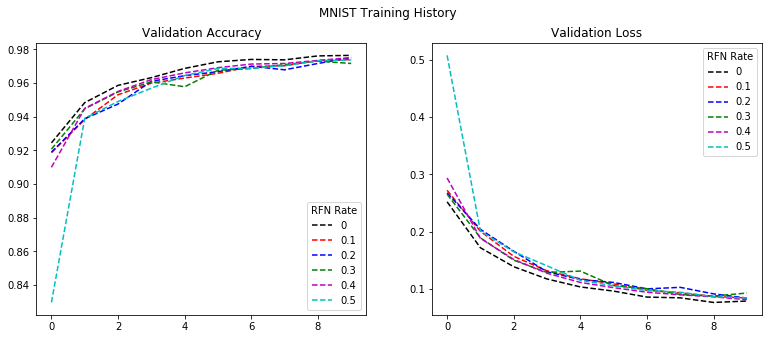

In [147]:
import matplotlib.pyplot as plt

colors = ['k', 'r', 'b', 'g', 'm', 'c']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13,5))
fig.suptitle('MNIST Training History')
ax[0].set_title('Validation Accuracy')
ax[1].set_title('Validation Loss')
for c, (k, v) in zip(colors, history.items()):
    ax[0].plot(range(10), v[0], c+'--', label=str(k))
    ax[1].plot(range(10), v[1], c+'--', label=str(k))
ax[0].legend(title='RFN Rate')
ax[1].legend(title='RFN Rate')

In [1]:
!nvidia-smi

Wed Nov 27 15:59:55 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 415.27       Driver Version: 415.27       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:01:00.0 Off |                  N/A |
| 54%   82C    P2   146W / 180W |   3974MiB /  8117MiB |     68%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  